# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [6]:
#Augmentation of training data in order to make model more reliable

train_augmented = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomVerticalFlip(p = 0.5),
    T.ToTensor(), #will convert array to tensor and 
    #shift from (height, width, channel) to (channel, height, width)
    T.Normalize(mean = 0.5, std = 0.5)
])

validation_augmented = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = 0.5, std = 0.5)
])

In [7]:
trainset = datasets.MNIST('./', download = False, train = True, transform = train_augmented) #we already have the dataset
testset = datasets.MNIST('./', download = False, train = False, transform = validation_augmented) #we already have the dataset

In [8]:
trainset, validationset = torch.utils.data.random_split(trainset, [50000,10000])

In [10]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validationset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


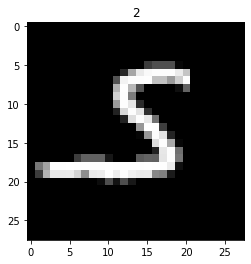

In [11]:
idx = 1
image, label = trainset[idx]

print(f'shape of image : {image.shape}') #we will get channel, height, width, because this is a tensor

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [12]:
from torch.utils.data import DataLoader

In [13]:
bs = 64
trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)
validationloader = DataLoader(validationset, batch_size = bs)
testloader = DataLoader(testset, batch_size = bs)

In [15]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validationloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [16]:
for images, labels in trainloader:
    print(f"One image batch shape is : {image.shape}")
    print(f"One labels batch shape is : {labels.shape}")
    break;

One image batch shape is : torch.Size([1, 28, 28])
One labels batch shape is : torch.Size([64])


# Load Model 

In [17]:
from models import DigitModel
model = DigitModel()
model.to('cpu') #we will load the model in CPU, not GPU, it is good practice to define this

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [22]:
#Training function
def train_function(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    
    for images, labels in tqdm(dataloader):
        images = images.to('cpu')
        labels = labels.to('cpu')
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_accuracy += utils.multiclass_accuracy(logits, labels)
        
    return total_loss / len(dataloader), total_accuracy / len(dataloader)

In [19]:
#Valudation function
def validation_function(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    
    with torch.no_grad():
    
        for images, labels in tqdm(dataloader):
            images = images.to('cpu')
            labels = labels.to('cpu')

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_accuracy += utils.multiclass_accuracy(logits, labels)

        return total_loss / len(dataloader), total_accuracy / len(dataloader)

# Training Loop 

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [24]:
best_validation_loss = np.Inf

for i in range(7): #epochs
    train_loss, train_accuracy = train_function(model, trainloader, criterion, optimizer)
    validation_loss, validation_accuracy = validation_function(model, trainloader, criterion)
    print(f"Epoch {i+1}... Trainloss : {train_loss}.... Train Accuracy: {train_accuracy} ")
    print(f"Epoch {i+1}... Validation loss : {validation_loss}.... Validation Accuracy: {validation_accuracy} ")
    
    if validation_loss < best_validation_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        print('Saved best model')
        best_validation_loss = validation_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1... Trainloss : 0.3939359156543489.... Train Accuracy: 0.8782169222831726 
Epoch 1... Validation loss : 0.1739120866169634.... Validation Accuracy: 0.9469909071922302 
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2... Trainloss : 0.3007915490414099.... Train Accuracy: 0.9081481695175171 
Epoch 2... Validation loss : 0.1597657617172012.... Validation Accuracy: 0.9525255560874939 
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3... Trainloss : 0.2663872084006324.... Train Accuracy: 0.9197770357131958 
Epoch 3... Validation loss : 0.13251196478476837.... Validation Accuracy: 0.9610373973846436 
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4... Trainloss : 0.24055271855343485.... Train Accuracy: 0.9274896383285522 
Epoch 4... Validation loss : 0.12184560390146416.... Validation Accuracy: 0.9628956317901611 
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5... Trainloss : 0.2222702210873861.... Train Accuracy: 0.934502899646759 
Epoch 5... Validation loss : 0.14088074814842638.... Validation Accuracy: 0.9560222029685974 


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6... Trainloss : 0.2123150669152627.... Train Accuracy: 0.9365409016609192 
Epoch 6... Validation loss : 0.11167611479354293.... Validation Accuracy: 0.9663123488426208 
Saved best model


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7... Trainloss : 0.20458234011021723.... Train Accuracy: 0.9394980669021606 
Epoch 7... Validation loss : 0.11088716713330515.... Validation Accuracy: 0.9666919708251953 
Saved best model


# Inference

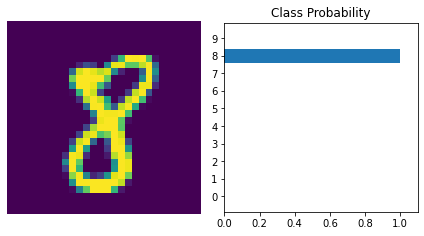

In [28]:
#Lets test our newly trained model
image, label = testset[134]
weights = torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()
with torch.no_grad():
    logits = model(image.unsqueeze(0)) #image in test is channel, height, width
    #with unsqueeze it becomes batchsize (1), channel, height, width
    probabilities = torch.nn.Softmax(dim = 1)(logits)[0]
    utils.view_classify(image, probabilities)
    